In [1]:
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import statistics as stats
import random

from imp import reload

from parameter_tuning import tune_rf, tune_xgb

from stacked_model import prepare_csv_data, train_stacked_model_full, test_stacked_model_full, prepare_csv_data_k_folds, feature_selection_fun_full

(1189, 51)
[16:01:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


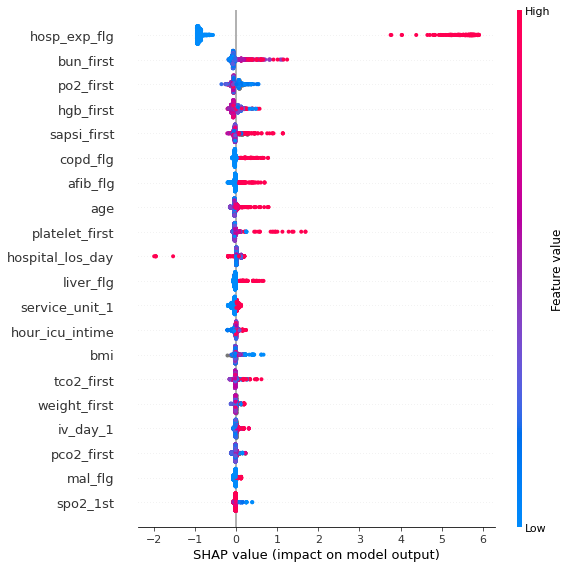

[16:01:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyError: "None of [Index(['aline_flgcoarse_proba', 'icu_los_daycoarse_proba',\n       'hospital_los_daycoarse_proba', 'agecoarse_proba',\n       'gender_numcoarse_proba', 'weight_firstcoarse_proba', 'bmicoarse_proba',\n       'sapsi_firstcoarse_proba', 'sofa_firstcoarse_proba',\n       'service_numcoarse_proba', 'day_icu_intime_numcoarse_proba',\n       'hour_icu_intimecoarse_proba', 'hosp_exp_flgcoarse_proba',\n       'icu_exp_flgcoarse_proba', 'sepsis_flgcoarse_proba',\n       'chf_flgcoarse_proba', 'afib_flgcoarse_proba', 'renal_flgcoarse_proba',\n       'liver_flgcoarse_proba', 'copd_flgcoarse_proba', 'cad_flgcoarse_proba',\n       'stroke_flgcoarse_proba', 'mal_flgcoarse_proba', 'resp_flgcoarse_proba',\n       'map_1stcoarse_proba', 'hr_1stcoarse_proba', 'temp_1stcoarse_proba',\n       'spo2_1stcoarse_proba', 'abg_countcoarse_proba',\n       'wbc_firstcoarse_proba', 'hgb_firstcoarse_proba',\n       'platelet_firstcoarse_proba', 'sodium_firstcoarse_proba',\n       'potassium_firstcoarse_proba', 'tco2_firstcoarse_proba',\n       'chloride_firstcoarse_proba', 'bun_firstcoarse_proba',\n       'creatinine_firstcoarse_proba', 'po2_firstcoarse_proba',\n       'pco2_firstcoarse_proba', 'iv_day_1coarse_proba',\n       'day_icu_intime_0coarse_proba', 'day_icu_intime_1coarse_proba',\n       'day_icu_intime_2coarse_proba', 'day_icu_intime_3coarse_proba',\n       'day_icu_intime_4coarse_proba', 'day_icu_intime_5coarse_proba',\n       'day_icu_intime_6coarse_proba', 'service_unit_0coarse_proba',\n       'service_unit_1coarse_proba', 'service_unit_2coarse_proba'],\n      dtype='object')] are in the [columns]"

In [42]:
filepath = 'Datasets/full_cohort_data.csv'
y_label = 'day_28_flg'
hot_encode_labels = ['day_icu_intime', 'service_unit']
features_to_drop = ['mort_day_censored', 'censor_flg']

X_train, X_test, y_train, y_test= prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop, operation='none')

# features = feature_selection_fun_full(X_train, y_train, selection_technique='roc', correlation=True)

features = X_train.columns

X_train = X_train[features]
X_test = X_test[features]

print(X_train.shape)

coarse_model = XGBClassifier(n_estimators=10, max_depth = 5)
coarse_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model=coarse_model, X=X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

for feat in features:
    X_train[feat +'_shap'] = [shap_values[n][X_train[features].columns.get_loc(feat)] for n in range(0, len(X_train[features]))]

X_train = X_train.assign(coarse_proba = coarse_model.predict_proba(X_train[features])[:, 1])

new_features = features + ['coarse_proba']

n_estimators = 200

max_depth = 5

regular_model =XGBClassifier(n_estimators=n_estimators, max_depth = max_depth).fit(X_train[features], y_train)

fine_model = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth).fit(X_train[new_features], y_train)

fine_model_shap = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth).fit(X_train.drop(columns=new_features), y_train)

proba = regular_model.predict_proba(X_train[features])[:, 1]
fpr, tpr, threshold = roc_curve(y_train, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

proba = fine_model.predict_proba(X_train[new_features])[:, 1]
fpr, tpr, threshold = roc_curve(y_train, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

print('ROC_NO_SHAP: ' + str(roc_auc))

proba = fine_model_shap.predict_proba(X_train.drop(columns=new_features))[:, 1]
fpr, tpr, threshold = roc_curve(y_train, proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)

print('ROC_SHAP: ' + str(roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

shap_values = explainer.shap_values(X_test)

for feat in features:
    X_test[feat +'_shap'] = [shap_values[n][X_train[features].columns.get_loc(feat)] for n in range(0, len(X_test[features]))]

X_test = X_test.assign(coarse_proba = coarse_model.predict_proba(X_test[features])[:, 1])

proba = regular_model.predict_proba(X_test[features])[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

proba = fine_model.predict_proba(X_test[new_features])[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

print('ROC_NO_SHAP: ' + str(roc_auc))

proba = fine_model_shap.predict_proba(X_test.drop(columns=new_features))[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)

print('ROC_SHAP: ' + str(roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

explainer = shap.TreeExplainer(model=fine_model_shap, X=X_train.drop(columns=new_features))
shap_values = explainer.shap_values(X_train.drop(columns=new_features))

shap.summary_plot(shap_values, X_train.drop(columns=new_features))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


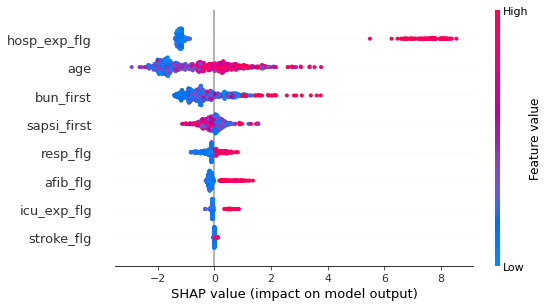

ROC_NO_SHAP: 0.9926666280953483
ROC_SHAP: 0.9993491090025457


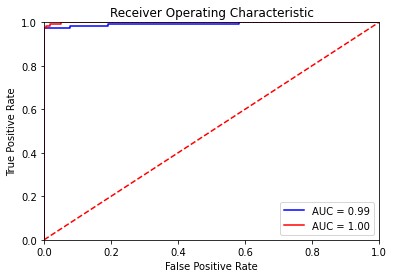

In [63]:
mu, sigma = 0, 0.1 

noise_shape = [X_train[features].shape[0], X_train[features].shape[1]]

noise = np.random.normal(mu, sigma, noise_shape)

X_train = X_train[features] + noise

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

for feat in features:
    X_train[feat +'_shap'] = [shap_values[n][X_train[features].columns.get_loc(feat)] for n in range(0, len(X_train[features]))]
    
X_train = X_train.assign(coarse_proba = coarse_model.predict_proba(X_train[features])[:, 1])

new_features = features + ['coarse_proba']

proba = fine_model.predict_proba(X_train[new_features])[:, 1]
fpr, tpr, threshold = roc_curve(y_train, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

print('ROC_NO_SHAP: ' + str(roc_auc))

proba = fine_model_shap.predict_proba(X_train)[:, 1]
fpr, tpr, threshold = roc_curve(y_train, proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)

print('ROC_SHAP: ' + str(roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()